In this recipe we'll perform several analyses that were originally published in [Lauber *et al.* (2009)](http://www.ncbi.nlm.nih.gov/pubmed/19502440) (commonly referred to as the *88 Soils* study). We'll focus on beta diversity analyses using scikit-bio, numpy, scipy, pandas, and matplotlib.

## Background

The *88 Soils* study analyzed bacterial communities in 88 soil samples taken from various locations in North and South America. The key finding of the study was that soil pH was significantly correlated with bacterial community composition. The study did not find strong correlation based on geographic location (e.g., latitude).

In this notebok, we'll reproduce several of the beta diversity analyses that lead to these conclusions. Our analyses will center around two key pieces of data: an unweighted [UniFrac](http://aem.asm.org/content/71/12/8228.abstract) distance matrix (e.g., as produced by [QIIME](http://qiime.org/)) containing distances between soil microbiome samples, and metadata about each soil sample (e.g., pH, latitude, soil moisture deficit, etc.; this is typically referred to as a *mapping file* in QIIME-related studies).

We won't include full details on how to generate a distance matrix from amplicon sequence data in this notebook, nor will we provide details about microbial ecology concepts and methodology (e.g., UniFrac, alpha/beta diversity, ordination techniques). For further reading, see the [Studying microbial diversity](http://readiab.org/book/latest/3/1) chapter of [*An Introduction to Applied Bioinformatics*](http://readiab.org/) and the tutorials on the [QIIME website](http://qiime.org/).

The original sequence data and metadata were obtained from the QIIME database (study 103), which is currently being re-vamped as [Qiita](https://github.com/biocore/qiita), and processed as follows:

1. The OTU table was generated using closed-reference OTU picking with QIIME 1.7.0 and [Greengenes](http://www.ncbi.nlm.nih.gov/pubmed/22134646) 13_8 97% OTUs. [uclust](http://bioinformatics.oxfordjournals.org/content/26/19/2460) was used as the underlying clustering method in `pick_closed_reference_otus.py` with the default 97% similarity.

2. The unweighted UniFrac distance matrix was generated using [MacQIIME](http://www.wernerlab.org/software/macqiime) 1.8.0 with the following command:

```
beta_diversity_through_plots.py -i table.biom -m map.txt -o bdiv-even500 -t /macqiime/greengenes/gg_13_8_otus/trees/97_otus.tree -e 500 -aO 6
```

**Note:** The distance matrix and per-sample metadata used here are not identical to the data used in the *88 Soils* publication. The data used here were derived from the publication's original sequencing data, but different processing steps were used here (e.g., different software and/or versions, parameters, reference database, etc.). Thus, the results presented here do not exactly match the publication's results, but we expect to arrive at the same overall biological conclusions.

## Getting started: loading the data

Before performing our analyses, we need to load the unweighted UniFrac distance matrix and metadata mapping file. Both are stored on disk as tab-separated text. We'll load the distance matrix into an [skbio.DistanceMatrix](http://scikit-bio.org/docs/0.5.0/generated/generated/skbio.stats.distance.DistanceMatrix.html) object and the metadata into a [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html):

In [1]:
import pandas as pd
from skbio import DistanceMatrix

unifrac_dm = DistanceMatrix.read('data/88-soils/dm.txt')
df = pd.read_csv('data/88-soils/map.txt', sep='\t', index_col=0)

Let's take a quick look at our distance matrix:

In [2]:
print(unifrac_dm)

85x85 distance matrix
IDs:
'LQ2.141729', 'IT2.141720', 'HI3.141676', 'MD2.141689', 'RT1.141654', ...
Data:
[[ 0.          0.72303965  0.75669608 ...,  0.75618327  0.71983899
   0.80723333]
 [ 0.72303965  0.          0.67136327 ...,  0.71516397  0.6448562
   0.7136385 ]
 [ 0.75669608  0.67136327  0.         ...,  0.67475805  0.75112105
   0.67771871]
 ..., 
 [ 0.75618327  0.71516397  0.67475805 ...,  0.          0.76704384
   0.68621643]
 [ 0.71983899  0.6448562   0.75112105 ...,  0.76704384  0.          0.77375735]
 [ 0.80723333  0.7136385   0.67771871 ...,  0.68621643  0.77375735  0.        ]]


Notice that there are only 85 soil samples -- we're a few samples shy of the original 88 (actually, there are 89 total samples, but only 88 were used in the original paper). We have fewer samples than the published paper because our *even sampling depth* of 500 sequences per sample caused samples with too few sequences to be dropped.

Now let's take a look at our metadata:

In [3]:
df

,BarcodeSequence,LinkerPrimerSequence,TARGET_SUBFRAGMENT,ASSIGNED_FROM_GEO,EXPERIMENT_CENTER,TITLE,RUN_PREFIX,TEXTURE,EXPERIMENT_ALIAS,DEPTH,...,PRIMER_READ_GROUP_TAG,PCR_PRIMERS,LIBRARY_CONSTRUCTION_PROTOCOL,ANNUAL_SEASON_PRECPT,LATITUDE,STUDY_REF,SOIL_MOISTURE_DEFICIT,REGION,STUDY_CENTER,Description
#SampleID,,,,,,,,,,,,,,,,,,,,,
IT2.141720,ACGTGCCGTAGA,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,loamy sand,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,750.0,47.183333,lauber_88_soils,-262,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
HI3.141676,ACGCTATCTGGA,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,loamy sand,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,1000.0,20.083333,lauber_88_soils,108,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
MD2.141689,ACTCGATTCGAT,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,sandy loam,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,150.0,34.900000,lauber_88_soils,1054,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
CA1.141704,ACACGAGCCACA,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,silt loam,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,400.0,36.050000,lauber_88_soils,198,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
PE5.141692,AGACTGCGTACT,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,clay loam,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,5000.0,-12.633333,lauber_88_soils,-1900,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
CO1.141714,ACATGATCGTTC,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,sand,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,600.0,40.400000,lauber_88_soils,-309,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
DF3.141696,ACCGCAGAGTCA,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,loamy sand,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,1100.0,35.966667,lauber_88_soils,-328,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
PE1.141715,ACTTGTAGCAGC,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,sandy loam,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,2100.0,-13.083333,lauber_88_soils,-2500,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...
SP2.141678,AGCGCTGATGTG,CATGCTGCCTCCCGTAGGAGT,V2,n,CCME,Pyrosequencing-Based Assessment of Soil pH as ...,FA6P1OK,loamy sand,lauber_88_soils,0-0.05,...,V2,FWD:GCCTTGCCAGCCCGCTCAGTCAGAGTTTGATCCTGGCTCAG;...,19502440,750.0,36.616667,lauber_88_soils,-402,0,CCME,Pyrosequencing_based_assessment_of_soil_pH_as_...


Notice that there are 89 samples in the metadata `DataFrame`, and that the order of sample IDs in the distance matrix and metadata are not the same. This is okay: scikit-bio generally allows metadata to be a *superset* of the IDs present in the distance matrix (or ordination results, or whatever else you're working with). In other words, extra sample IDs in the metadata are okay, and they don't have to be in the same order as they are in the distance matrix.

**Note:** scikit-bio currently only allows the metadata to be a superset of the IDs in the distance matrix. There are plans to support other modes, e.g., intersecting the metadata and distance matrix, or ignoring distance matrix IDs that are not found in the mapping file. See [#756](https://github.com/biocore/scikit-bio/issues/756) to track progress on this.

## Visualizing beta diversity with ordination techniques

Now that we have our data loaded, let's visually explore the beta diversity of the 85 soils samples in our distance matrix, in the context of our per-sample metadata.

The authors presented NMDS ordination plots of the soil samples colored by pH and biome. scikit-bio doesn't have the NMDS ordination technique yet -- there's an open issue (see [#99](https://github.com/biocore/scikit-bio/issues/99)) to have this functionality added. However, we can produce similar results using principal coordinates analysis (PCoA):

In [4]:
from skbio.stats.ordination import pcoa

pcoa_results = pcoa(unifrac_dm)

Plot the PCoA results, coloring each soil sample (i.e., each point) with its latitude:

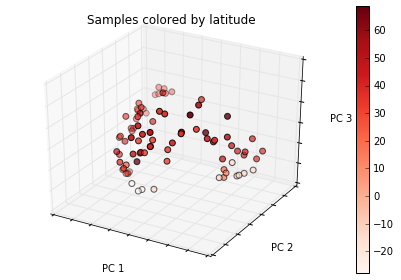

In [5]:
# display matplotlib figures within the notebook
%matplotlib inline

fig = pcoa_results.plot(df=df,
                        column='LATITUDE',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by latitude',
                        cmap='Reds',
                        s=35)

There isn't much of a gradient pattern in the plot; this confirms the findings of the paper.

If we color the soil samples by their pH, we see a clear gradient pattern from left (basic) to right (acidic). This visually confirms the correlation between soil bacterial community composition and change in pH that was the key finding in the paper. 

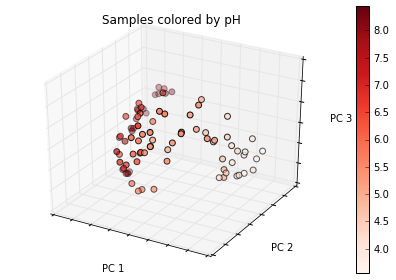

In [6]:
fig = pcoa_results.plot(df=df,
                        column='PH',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by pH',
                        cmap='Reds',
                        s=35)

The only other environmental variable that was found to have significant correlation with community composition was soil moisture deficit:

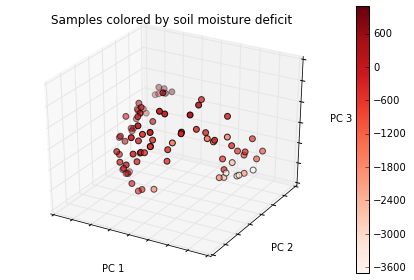

In [7]:
fig = pcoa_results.plot(df=df,
                        column='SOIL_MOISTURE_DEFICIT',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by soil moisture deficit',
                        cmap='Reds',
                        s=35)

We see a pattern that's somewhat similar to the pH plot above. As the paper points out, pH and soil moisture deficit are strongly correlated environmental variables, which we confirm here by computing Pearson's correlation coefficient $r$:

In [8]:
from scipy.stats import pearsonr

pearsonr(df['PH'], df['SOIL_MOISTURE_DEFICIT'])[0]

0.65196220317643994

**Note:** The ordination plotting functionalty available in sckit-bio creates basic plots, and is intended to provide a quick look at your results in the context of metadata. For more interactivity, customization, and to generate publication-quality figures, we recommend EMPeror ([paper](http://www.gigasciencejournal.com/content/2/1/16/) | [website](http://biocore.github.io/emperor/)).

To write the ordination results to file so that they can be loaded in EMPeror, run:

In [9]:
pcoa_results.write('data/88-soils/pcoa_results.txt')

'data/88-soils/pcoa_results.txt'

## Comparing distance matrices with the Mantel test

Now that we've visually explored beta diversity in the context of latitude, pH, and soil moisture deficit, let's quantify the strength of the relationships between community composition and environmental variables. There are a variety of techniques that can accomplish this; the original paper used the [Mantel test](http://www.ncbi.nlm.nih.gov/pubmed/6018555) to compute the correlation between the unweighted UniFrac distance matrix and distance matrices derived from environmental variables. We will replicate those analyses here.

Let's define a convenience function to compute a `DistanceMatrix` from a numeric environmental variable (stored as a column in a `DataFrame`). We'll use the Euclidean distance metric:

In [10]:
import numpy as np
import scipy.spatial.distance

def dm_from_env(df, column):
    distances = scipy.spatial.distance.pdist(df[column].values[:, np.newaxis], metric='euclidean')
    return DistanceMatrix(distances, ids=df.index)

Let's create three distance matrices from our metadata (pH, soil moisture deficit, and latitude):

In [11]:
ph_dm = dm_from_env(df, 'PH')
soil_mois_dm = dm_from_env(df, 'SOIL_MOISTURE_DEFICIT')
latitude_dm = dm_from_env(df, 'LATITUDE')

We can use the Mantel test in scikit-bio to compare the UniFrac distance matrix with each of the environmental distance matrices. We use Spearman correlation instead of Pearson correlation (the default) to match the original publication:

In [12]:
from skbio.stats.distance import mantel

mantel(unifrac_dm, ph_dm, method='spearman', strict=False)

(0.77870091183431622, 0.001, 85)

We receive three values: the correlation coefficient (Spearman's $\rho$), p-value, and number of samples that matched between the two distance matrices.

Note that 85 samples were used in the test. The metadata has 89 samples but our UniFrac distance matrix only has 85 samples, so the Mantel test only considered samples that were in **both** distance matrices (controlled via `strict=False`). Just as scikit-bio doesn't require the metadata and distance matrix to be in the same order, the Mantel test reorders the samples in each distance matrix before comparing them. See the [scikit-bio mantel documentation](http://scikit-bio.org/docs/0.5.0/generated/generated/skbio.stats.distance.mantel.html) for more details.

Let's run the Mantel test on the other two environmental distance matrices we created:

In [13]:
mantel(unifrac_dm, soil_mois_dm, method='spearman', strict=False)

(0.42167110480728659, 0.001, 85)

In [14]:
mantel(unifrac_dm, latitude_dm, method='spearman', strict=False)

(0.22958919478208206, 0.001, 85)

pH has strong correlation ($\rho$=0.7787) with soil microbial community composition, which agrees with the major points made in the original *88 Soils* publication. Soil moisture deficit has moderate correlation ($\rho=0.4217$), while latitude has weak correlation ($\rho=0.2296$). These findings are also in line with the original study results.

**Note:** The p-value reported for UniFrac versus latitude differs from the p-value reported in the original publication ($P > 0.15$), which was computed using [PRIMER v6](http://www.primer-e.com/). We are actively investigating the discrepancy between p-values, as the paper did not find significant results, while our notebook finds significant results.

Instead of running each Mantel test separately, scikit-bio provides a convenience function for running Mantel tests for all pairs of distance matrices:

In [15]:
from skbio.stats.distance import pwmantel

pwmantel([unifrac_dm, ph_dm, soil_mois_dm, latitude_dm],
         labels=['UniFrac', 'pH', 'Soil moisture deficit', 'Latitude'],
         method='spearman', strict=False)

statistic  p-value   n    method  \
dm1                   dm2                                                       
UniFrac               pH                      0.778701    0.001  85  spearman   
                      Soil moisture deficit   0.421671    0.001  85  spearman   
                      Latitude                0.229589    0.001  85  spearman   
pH                    Soil moisture deficit   0.348139    0.001  89  spearman   
                      Latitude                0.069542    0.037  89  spearman   
Soil moisture deficit Latitude                0.318524    0.001  89  spearman   

                                             permutations alternative  
dm1                   dm2                                              
UniFrac               pH                              999   two-sided  
                      Soil moisture deficit           999   two-sided  
                      Latitude                        999   two-sided  
pH                    Soil moisture deficit           999   two-sided  
                      Latitude                        999   two-sided  
Soil moisture deficit Latitude                        999   two-sided

We obtain the same results as above, but this time they are presented in a `DataFrame`.

<font color="red">**Warning:**</font> `pwmantel` doesn't correct the p-values for multiple comparisons (e.g., Bonferroni correction). It is the responsibility of the user to correct the p-values, though this feature may be added to scikit-bio in the future.

## Linking evironmental variables to community structure

Besides pH, soil moisture deficit, and latitude, there are many more environmental variables in our `DataFrame` that we haven't explored yet. Table 2 in the original paper has Mantel test results for several other evironmental variables, with a note stating that many more were analyzed but no significant correlations were found. The paper also states that multivariate correlations did not increase the strength of the correlation coefficients; thus, single environmental variables had higher correlation than combinations of two or more environmental variables.

When there are a large number of environmental variables of potential interest, the `bioenv` method (originally called BIO-ENV, also known as BEST) can be helpful in finding subsets of variables that are maximally rank-correlated with the community distance matrix. See [Clarke & Ainsworth (1993)](http://www.int-res.com/articles/meps/92/m092p205.pdf) for the original method publication and the [scikit-bio bioenv documentation](http://scikit-bio.org/docs/0.5.0/generated/generated/skbio.stats.distance.bioenv.html) for more details.

Let's define a list of 11 numeric environmental variables of potential interest. The names match the column names in the `DataFrame`:

In [16]:
env_vars = [
    'TOT_ORG_CARB', 'SILT_CLAY', 'ELEVATION', 'SOIL_MOISTURE_DEFICIT',
    'CARB_NITRO_RATIO', 'ANNUAL_SEASON_TEMP', 'ANNUAL_SEASON_PRECPT',
    'PH', 'CMIN_RATE', 'LONGITUDE', 'LATITUDE'
]

Let's run `bioenv` with our UniFrac distance matrix, metadata, and environmental variables we defined above:

In [17]:
from skbio.stats.distance import bioenv

res = bioenv(unifrac_dm, df, env_vars)
res

,size,correlation
vars,,
PH,1,0.778703
"SOIL_MOISTURE_DEFICIT, PH",2,0.706704
"SOIL_MOISTURE_DEFICIT, ANNUAL_SEASON_TEMP, PH",3,0.666790
"SILT_CLAY, SOIL_MOISTURE_DEFICIT, ANNUAL_SEASON_TEMP, PH",4,0.629411
"SILT_CLAY, SOIL_MOISTURE_DEFICIT, CARB_NITRO_RATIO, ANNUAL_SEASON_TEMP, PH",5,0.594918
"SILT_CLAY, SOIL_MOISTURE_DEFICIT, CARB_NITRO_RATIO, ANNUAL_SEASON_TEMP, PH, LONGITUDE",6,0.575953
"SILT_CLAY, SOIL_MOISTURE_DEFICIT, CARB_NITRO_RATIO, ANNUAL_SEASON_TEMP, ANNUAL_SEASON_PRECPT, PH, LONGITUDE",7,0.553162
"TOT_ORG_CARB, SILT_CLAY, SOIL_MOISTURE_DEFICIT, CARB_NITRO_RATIO, ANNUAL_SEASON_TEMP, ANNUAL_SEASON_PRECPT, PH, LONGITUDE",8,0.535103
"TOT_ORG_CARB, SILT_CLAY, SOIL_MOISTURE_DEFICIT, CARB_NITRO_RATIO, ANNUAL_SEASON_TEMP, ANNUAL_SEASON_PRECPT, PH, CMIN_RATE, LONGITUDE",9,0.509554


We see that the "best" subset of environmental variables is a subset of size 1, which only includes pH. This result confirms the findings of the paper: not only is pH strongly correlated with community composition, but including multiple environmental variables doesn't improve the correlation over using pH alone.

Also note that pH and soil moisture deficit are the "best" subset for subset size 2. This intuitively makes sense because pH and soil moisture deficit are strongly correlated (we calculated this earlier).

The results are stored as a `DataFrame`, so we can easily find the subset of environmental variables with the highest correlation. In this example, it's easy to find the largest correlation coefficient (it's pH), but the following technique can be handy if the results table is large:

In [18]:
res['correlation'].idxmax()

'PH'

`bioenv` was not used in the original paper, but it can be a useful technique when there are a large number of environmental variables.